<a href="https://colab.research.google.com/github/terryljh/aviation2/blob/main/asrs%20linear%20model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
#collect all csvs in one list to read them all into one dataframe
csv_urls = [
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/jan2005-jun2005.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/jul2005-mar2006.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/april2006-november2006.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2006-august2007.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2007-may2008.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2008-february2009.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/march2009-november2009.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2009-august2010.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2010-may2011.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2011-february2012.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/march2012-november2012.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2012-august2013.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/september2013-may2014.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2014-april2015.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2015-january2016.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/february2016-december2016.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/january2017-november2017.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/december2017-october2018.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/november2018-july2019.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/august2019-may2020.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/june2020-april2021.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2021-apr2022.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/may2022-mar2023.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/apr2023-mar2024.csv',
    'https://github.com/terryljh/aviation2/raw/refs/heads/main/ASRS%20data/apr2024-dec2025.csv']
    #this code usually takes about 15-30 seconds to read in all csv's
df = pd.concat([pd.read_csv(url) for url in csv_urls], ignore_index=True)
pd.set_option('display.max_columns', None)
new_headers = df.iloc[0] #dataset has headers, then the first row is the actual headings,
#so we want to replace headers with the first row new_headers

#removes anomolous dates that are in by mistake, should only be April 2024-May 2025

# Make the headers unique, in case some are repeated, function relabels 2,3 etc
#The ASRS occasionally has multiple reports for a single incident
#If we want to include second,third reports in our data, we need to include the
#second version of those columns too, but for simplicity maybe we only take the
#first report of each incident for now?
def make_unique(headers):
    counts = {}
    unique_headers = []
    for col in headers:
        if col in counts:
            counts[col] += 1
            unique_headers.append(f"{col}_{counts[col]}")
        else:
            counts[col] = 0
            unique_headers.append(col)
    return unique_headers
unique_headers = make_unique(new_headers)

df.columns = unique_headers
df = df.iloc[1:].reset_index(drop=True) #remove unnecessary first row

df['Date']= df['Date'].values
df['Date'] = pd.to_numeric(df['Date'], errors='coerce')
#the date column is of type string, we change to integer so we can manipulate it
#errors='coerce' will return NaN if not a number

# make normalized column from state ref column  where:
# make all upper case
# strip leading or trailing white space

df['Normalized'] = df['State Reference'].str.upper().str.strip()

#Define U.S. state abbreviations (includes DC)
us_states = {
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
}

#Define set of ISO alpha-2 country codes
country_codes = {
    'AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AW', 'AX', 'AZ',
    'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BL', 'BM', 'BN', 'BO', 'BQ', 'BR', 'BS', 'BT', 'BV', 'BW', 'BY', 'BZ',
    'CA', 'CC', 'CD', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CO', 'CR', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ',
    'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'EH', 'ER', 'ES', 'ET',
    'FI', 'FJ', 'FM', 'FO', 'FR','GA', 'GB', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GT', 'GU', 'GW', 'GY',
    'HK', 'HM', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IO', 'IQ', 'IR', 'IS', 'IT',
    'JE', 'JM', 'JO', 'JP','KE', 'KG', 'KH', 'KI', 'KM', 'KN', 'KP', 'KR', 'KW', 'KY', 'KZ',
    'LA', 'LB', 'LC', 'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY',
    'MA', 'MC', 'MD', 'ME', 'MF', 'MG', 'MH', 'MK', 'ML', 'MM', 'MN', 'MO', 'MP', 'MQ', 'MR', 'MS', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ',
    'NA', 'NC', 'NE', 'NF', 'NG', 'NI', 'NL', 'NO', 'NP', 'NR', 'NU', 'NZ', 'OM','PA', 'PE', 'PF', 'PG', 'PH', 'PK', 'PL', 'PM', 'PN', 'PR', 'PT', 'PW', 'PY',
    'QA', 'RE', 'RO', 'RS', 'RU', 'RW', 'SA', 'SB', 'SC', 'SD', 'SE', 'SG', 'SH', 'SI', 'SJ', 'SK', 'SL', 'SM', 'SN', 'SO', 'SR', 'SS', 'ST', 'SV', 'SX', 'SY', 'SZ',
    'TC', 'TD', 'TF', 'TG', 'TH', 'TJ', 'TK', 'TL', 'TM', 'TN', 'TO', 'TR', 'TT', 'TV', 'TZ',
    'UA', 'UG', 'UM', 'US', 'UY', 'UZ', 'VA', 'VC', 'VE', 'VG', 'VI', 'VN', 'VU', 'WF', 'WS', 'YE', 'YT', 'ZA', 'ZM', 'ZW'
}


In [48]:
df.head(100)  # Show the first 10 rows
df.tail(10)  # Show the last 10 rows

,ACN,Date,Local Time Of Day,Locale Reference,State Reference,Relative Position.Angle.Radial,Relative Position.Distance.Nautical Miles,Altitude.AGL.Single Value,Altitude.MSL.Single Value,Latitude / Longitude (UAS),Flight Conditions,Weather Elements / Visibility,Work Environment Factor,Light,Ceiling,RVR.Single Value,ATC / Advisory,Aircraft Operator,Make Model Name,Aircraft Zone,Crew Size,Operating Under FAR Part,Flight Plan,Mission,Nav In Use,Flight Phase,Route In Use,Airspace,Maintenance Status.Maintenance Deferred,Maintenance Status.Records Complete,Maintenance Status.Released For Service,Maintenance Status.Required / Correct Doc On Board,Maintenance Status.Maintenance Type,Maintenance Status.Maintenance Items Involved,Cabin Lighting,Number Of Seats.Number,Passengers On Board.Number,Crew Size Flight Attendant.Number Of Crew,Airspace Authorization Provider (UAS),Operating Under Waivers / Exemptions / Authorizations (UAS),Waivers / Exemptions / Authorizations (UAS),Airworthiness Certification (UAS),Weight Category (UAS),Configuration (UAS),Flight Operated As (UAS),Flight Operated with Visual Observer (UAS),Control Mode (UAS),Flying In / Near / Over (UAS),Passenger Capable (UAS),Type (UAS),Number of UAS Being Controlled (UAS),Aircraft Component,Manufacturer,Aircraft Reference,Problem,ATC / Advisory_1,Aircraft Operator_1,Make Model Name_1,Aircraft Zone_1,Crew Size_1,Operating Under FAR Part_1,Flight Plan_1,Mission_1,Nav In Use_1,Flight Phase_1,Route In Use_1,Airspace_1,Maintenance Status.Maintenance Deferred_1,Maintenance Status.Records Complete_1,Maintenance Status.Released For Service_1,Maintenance Status.Required / Correct Doc On Board_1,Maintenance Status.Maintenance Type_1,Maintenance Status.Maintenance Items Involved_1,Cabin Lighting_1,Number Of Seats.Number_1,Passengers On Board.Number_1,Crew Size Flight Attendant.Number Of Crew_1,Airspace Authorization Provider (UAS)_1,Operating Under Waivers / Exemptions / Authorizations (UAS)_1,Waivers / Exemptions / Authorizations (UAS)_1,Airworthiness Certification (UAS)_1,Weight Category (UAS)_1,Configuration (UAS)_1,Flight Operated As (UAS)_1,Flight Operated with Visual Observer (UAS)_1,Control Mode (UAS)_1,Flying In / Near / Over (UAS)_1,Passenger Capable (UAS)_1,Type (UAS)_1,Number of UAS Being Controlled (UAS)_1,Location Of Person,Location In Aircraft,Reporter Organization,Function,Qualification,Experience,Cabin Activity,Human Factors,Communication Breakdown,UAS Communication Breakdown,ASRS Report Number.Accession Number,Location Of Person_1,Location In Aircraft_1,Reporter Organization_1,Function_1,Qualification_1,Experience_1,Cabin Activity_1,Human Factors_1,Communication Breakdown_1,UAS Communication Breakdown_1,ASRS Report Number.Accession Number_1,Anomaly,Miss Distance,Were Passengers Involved In Event,Detector,When Detected,Result,Contributing Factors / Situations,Primary Problem,Narrative,Callback,Narrative_1,Callback_1,Synopsis,NaN,Normalized
106581,2219623,202503.0,0601-1200,ATL.Airport,GA,NaN,NaN,NaN,2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRACON A80,Air Carrier,Regional Jet 900 (CRJ900),NaN,2,Part 121,IFR,Passenger,NaN,Initial Approach,NaN,Class B ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRACON A80,Air Carrier,A320,NaN,NaN,Part 121,IFR,NaN,NaN,Initial Approach,NaN,Class B ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aircraft X,Flight Deck,Air Carrier,Captain; Pilot Not Flying,Flight Crew Air Transport Pilot (ATP); Flight ...,Flight Crew Type 1054,NaN,Situational Awareness,NaN,NaN,2219623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inflight Event / Encounter Loss Of Aircraft Co...,NaN,NaN,Person Flight Crew,In-flight,Flight Crew Regained Aircraft Control,Environment - Non Weather Related; Human Facto...,Ambiguous,We were being vectored for a visual approach t...,Reporter stated he is not sure which aircraft ...,NaN,NaN,CRJ-900 Captain reported encountering si

In [8]:
# make a copy of cleaned data
df_cleaned = df.copy()

#  Initial classification of State, Country or 'State or Country' or Unknown
df_cleaned['Is_State'] = df_cleaned['Normalized'].isin(us_states)
df_cleaned['Is_Country'] = df_cleaned['Normalized'].isin(country_codes)
df_cleaned['Is_Ambiguous'] = df_cleaned['Is_State'] & df_cleaned['Is_Country']

def classify_abbreviation(row):
    if row['Is_Ambiguous']:
        return 'State or Country'
    elif row['Is_State']:
        return 'State'
    elif row['Is_Country']:
        return 'Country'
    else:
        return 'Unknown'

df_cleaned['Abbreviation_Type'] = df_cleaned.apply(classify_abbreviation, axis=1)

# Filter only valid 2-character abbreviations
df_cleaned['Length_Valid'] = df_cleaned['Normalized'].str.len() == 2
df_final = df_cleaned[df_cleaned['Length_Valid']].copy()

# Load airport codes from FreightPaul featured freight airport code system (IATA)
airport_codes = pd.read_csv("https://github.com/terryljh/aviation2/raw/refs/heads/main/airports.csv")

# Extract 3-letter airport code from Locale Reference
df_final.loc[:, 'Airport_Code'] = df_final['Locale Reference'].str[:3]

# Update ambiguous or unknown using airport data
needs_update = df_final['Abbreviation_Type'].isin(['Unknown', 'State or Country'])
df_to_update = df_final[needs_update].copy()

df_to_update = df_to_update.merge(
    airport_codes[['abrv', 'Code']],
    left_on='Airport_Code',
    right_on='abrv',
    how='left'
)

def resolve_from_airport(row):
    if pd.isna(row['Code']):
        return row['Abbreviation_Type']
    elif row['Code'] == 'US':
        return 'State'
    else:
        return 'Country'

df_to_update['Resolved_Type'] = df_to_update.apply(resolve_from_airport, axis=1)

# Update back into df_final
for idx, row in df_to_update.iterrows():
    df_final.loc[idx, 'Abbreviation_Type'] = row['Resolved_Type']

# Safeguard — always treat 'US' as a country
df_final.loc[df_final['Normalized'] == 'US', 'Abbreviation_Type'] = 'Country'
df_final.loc[df_final['State Reference'].str.strip().str.upper() == 'US', 'Abbreviation_Type'] = 'Country'

# apply fallback logic to any rows still ambiguous
still_uncertain = df_final['Abbreviation_Type'].isin(['State or Country', 'Unknown'])

def final_disambiguation(code):
    if code in us_states:
        return 'State'
    elif code in country_codes:
        return 'Country'
    else:
        return 'Unknown'

df_final.loc[still_uncertain, 'Abbreviation_Type'] = df_final.loc[still_uncertain, 'Normalized'].apply(final_disambiguation)

#output_path = ""C:\Users\dellx\Desktop\airport-codes.csv""
#df_final.to_csv(output_path, index=False)
#print(f" Final cleaned file saved to: {output_path}")

#print(df_final['Abbreviation_Type'].value_counts())

#there were some Canadian abbrevations that weren't in the original country codes so they were made outted to all be labeled as "Country"

# Define Canadian province abbreviations to treat as countries
canadian_provinces = {'ON', 'AB', 'BC', 'PQ', 'NB', 'MB', 'NS'}

#file_path = "C:/Users/steph/Downloads/final_state_country_with_airports.csv"
#df = pd.read_csv(file_path)

# Normalize again just in case
df_final['Normalized'] = df_final['Normalized'].str.upper().str.strip()

df_final.loc[df_final['Normalized'].isin(canadian_provinces), 'Abbreviation_Type'] = 'Country'

#df_final.to_csv(file_path, index=False)
#print(f" Updated Canadian provinces labeled as 'Country' and saved to: {file_path}")

dfsubset = df_final[['Date', 'Normalized', 'Abbreviation_Type', 'Locale Reference', 'State Reference', 'Operating Under FAR Part','Mission','Light', 'Flight Phase','Function', 'Contributing Factors / Situations', 'Primary Problem']]
dfsubset=dfsubset.copy()
dfsubset = dfsubset[(dfsubset['Date']//100 >= 2004) & (dfsubset['Date']//100 <= 2026)]
# there are accidentally some lines where the year is 0 BC, so we remove them


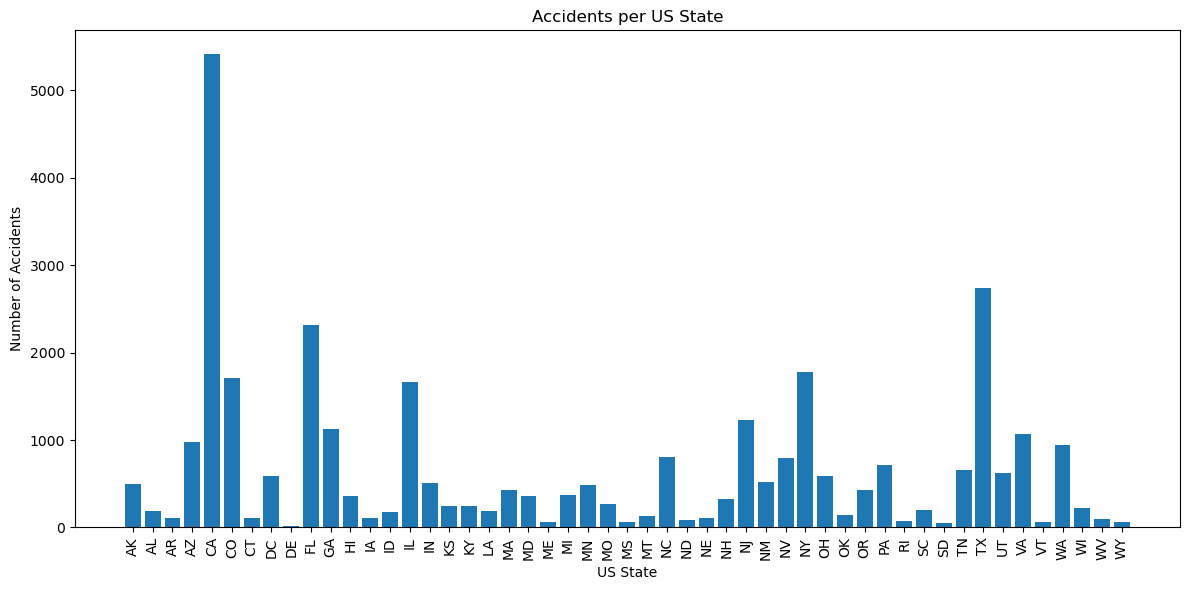

In [4]:
# Barplot with Number of Accidents per US state

df_filtered = dfsubset[dfsubset['Abbreviation_Type']=='State']

grouped = df_filtered.groupby('Normalized').size().reset_index(name='Accident_Count')

import matplotlib.pyplot

plt.figure(figsize = (12, 6))
plt.bar(grouped['Normalized'], grouped['Accident_Count'])
plt.xticks(rotation=90)
plt.xlabel('US State')
plt.ylabel('Number of Accidents')
plt.title('Accidents per US State')
plt.tight_layout()
plt.show()

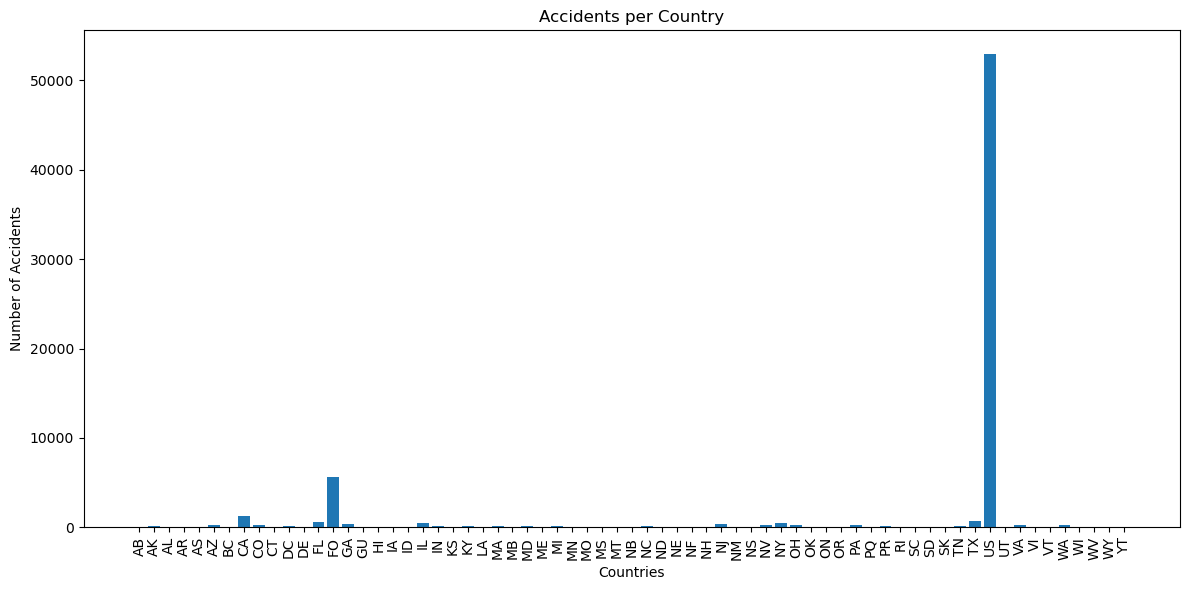

In [5]:
# Barplot with Number of Accidents per Country

df_filtered = dfsubset[dfsubset['Abbreviation_Type']=='Country']

grouped = df_filtered.groupby('Normalized').size().reset_index(name='Accident_Count')

import matplotlib.pyplot

plt.figure(figsize = (12, 6))
plt.bar(grouped['Normalized'], grouped['Accident_Count'])
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.ylabel('Number of Accidents')
plt.title('Accidents per Country')
plt.tight_layout()
plt.show()

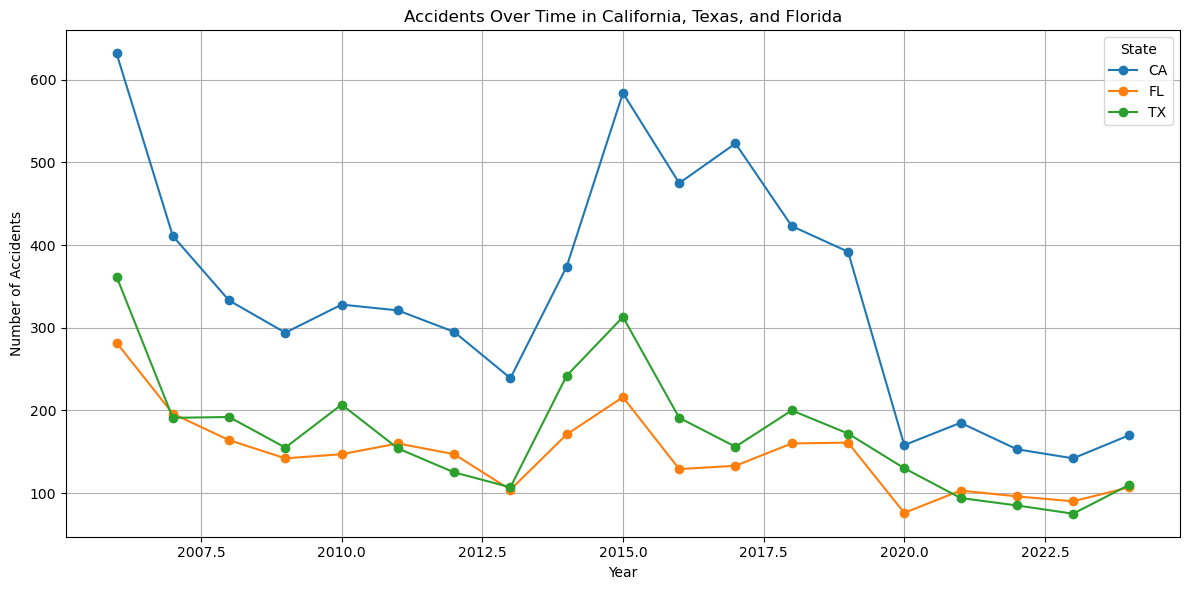

In [6]:
#scatterplot for accidents over time in top 3 states with accidents: California, Texas, and Florida
import pandas as pd
import matplotlib.pyplot as plt

#year column creation
dfsubset2 = df_final.copy()
dfsubset2['Date'] = pd.to_numeric(dfsubset2['Date'], errors='coerce')
dfsubset2 = dfsubset2[(dfsubset2['Date'] // 100 >= 2006) & (dfsubset2['Date'] // 100 <= 2024)]
dfsubset2['Year'] = dfsubset2['Date'] // 100

# number of accidents per year
yearly_counts = dfsubset2.groupby('Year').size().reset_index(name='Accident_Count')

#Line plot of CA, TX, FL
top_states = ['CA', 'TX', 'FL']
df_states = dfsubset2[dfsubset2['Normalized'].isin(top_states)]

# Group by year and state
grouped_states = df_states.groupby(['Year', 'Normalized']).size().reset_index(name='Accident_Count')
pivoted = grouped_states.pivot(index='Year', columns='Normalized', values='Accident_Count')

# Line plot
pivoted.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Accidents Over Time in California, Texas, and Florida')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.tight_layout()
plt.legend(title='State')
plt.show()



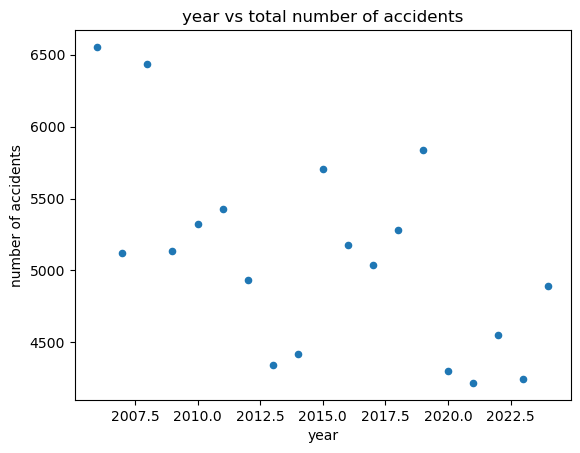

LinearRegression()

In [9]:
dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
#for the yearly counts, we cannot include 2025, because the data is not complete
#we do not include 2005 because anonymised reporting began in 2006
yearly_counts = dfsubset2.groupby(dfsubset2['Date']//100).size().reset_index(name='Accident_Count')
yearly_counts.plot.scatter(x='Date', y='Accident_Count')
plt.title('year vs total number of accidents')
plt.xlabel('year')
plt.ylabel('number of accidents')
plt.show()

from sklearn.model_selection import train_test_split

X, y = yearly_counts[['Date']], yearly_counts['Accident_Count']

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=945)

from sklearn.linear_model import LinearRegression
slryearly = LinearRegression()
slryearly.fit(X_train,y_train)

In [10]:
#re-doing the above with sm so we can use model summary
#decreasing trend but unreliable p-value
import statsmodels.api as sm
dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
yearly_counts = dfsubset2.groupby(dfsubset2['Date']//100).size().reset_index(name='Accident_Count')
yearly_counts.rename(columns={yearly_counts.columns[0]: 'Year'}, inplace=True)
X = sm.add_constant(yearly_counts['Year'])
y = yearly_counts['Accident_Count']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=945)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Accident_Count   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     6.596
Date:                Thu, 12 Jun 2025   Prob (F-statistic):             0.0234
Time:                        13:57:32   Log-Likelihood:                -109.86
No. Observations:                  15   AIC:                             223.7
Df Residuals:                      13   BIC:                             225.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.061e+05   3.94e+04      2.693      0.0

/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [11]:
#trying monthly counts instead of yearly counts, but without distinguishing months
#shows decreasing trend but unreliable p-value
import statsmodels.api as sm

dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]

monthly_counts = dfsubset2.groupby(dfsubset2['Date']%100).size().reset_index(name='Accident_Count_Per_Month')
monthly_counts.rename(columns={monthly_counts.columns[0]: 'Month'}, inplace=True)

X = sm.add_constant(monthly_counts['Month'])
y = monthly_counts['Accident_Count_Per_Month']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=945)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     Accident_Count_Per_Month   R-squared:                       0.147
Model:                                  OLS   Adj. R-squared:                  0.025
Method:                       Least Squares   F-statistic:                     1.205
Date:                      Thu, 12 Jun 2025   Prob (F-statistic):              0.309
Time:                              13:57:52   Log-Likelihood:                -65.787
No. Observations:                         9   AIC:                             135.6
Df Residuals:                             7   BIC:                             136.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [12]:
#model with only months as categorical variables and year as feature shows clear decreasing accident trend over year
#we use other variables in cells below
import statsmodels.api as sm
dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
dfsubset2=dfsubset2.copy()
dfsubset2['Year'] = dfsubset2['Date']//100
dfsubset2['Month'] = dfsubset2['Date']%100

grouped = dfsubset2.groupby(['Year', 'Month']).size().reset_index(name='count')

grouped['Month'] = grouped['Month'].astype(int)

month_dummies = pd.get_dummies(grouped['Month'], prefix='Month', drop_first=True)

grouped['Year'] = pd.to_numeric(grouped['Year'], errors='coerce')

X = pd.concat([grouped[['Year']].astype(float), month_dummies.astype(float)], axis=1)
y = grouped['count'].astype(float)

X = X.apply(pd.to_numeric, errors='coerce').dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=945)
#monthmodel = LinearRegression()
#monthmodel.fit(X_train,y_train)

X_train = sm.add_constant(X_train, prepend=False)

monthmodel2 = sm.OLS(y_train, X_train).fit()
monthmodel2.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     4.960
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           5.15e-07
Time:                        13:57:56   Log-Likelihood:                -1042.5
No. Observations:                 182   AIC:                             2111.
Df Residuals:                     169   BIC:                             2153.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year          -6.0155      1.060     -5.674      0.000      -8.108      -3.923
Month_2      -44.6676     28.285     -1.579      0.116    -100.505      11.170
Month_3       -3.9739     26.895     -0.148      0.883     -57.068      49.120
Month_4        2.3798     27.296      0.087      0.931     -51.506      56.266
Month_5       11.6098     26.891      0.432      0.666     -41.475      64.695
Month_6       45.7253     29.482      1.551      0.123     -12.476     103.927
Month_7       72.8169     28.254      2.577      0.011      17.041     128.593
Month_8       45.5816     28.275      1.612      0.109     -10.236     101.400
Month_9       -1.4288     27.301     -0.052      0.958     -55.324      52.466
Month_10       6.6619     28.257      0.236      0.814     -49.121      62.445
Month_11       2.7952     27.767      0.101      0.920     -52.020      57.610
Month_12       4.9627     26.891      0.185      0.854     -48.123      58.048
const       1.253e+04   2135.799      5.868      0.000    8316.578    1.67e+04
==============================================================================
Omnibus:                        6.087   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                8.507
Skew:                           0.156   Prob(JB):                       0.0142
Kurtosis:                       4.012   Cond. No.                     7.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#introduce other variables as features, e.g. percentage due to human factors
import statsmodels.api as sm

dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
dfsubset2=dfsubset2.copy()
dfsubset2['Year'] = dfsubset2['Date']//100
dfsubset2['Month'] = dfsubset2['Date']%100

dfsubset2['Human_Factors'] = dfsubset2['Primary Problem'] == 'Human Factors'
hf_by_month = dfsubset2.groupby(['Year', 'Month'])['Human_Factors'].mean().reset_index(name='pct_human_factors')
#hftotal_by_month = dfsubset2.groupby(['Year', 'Month'])['Human_Factors'].mean().reset_index(name='pct_human_factors')

dfsubset2['Aircraft'] = dfsubset2['Primary Problem'] == 'Aircraft'
aircraft_by_month = dfsubset2.groupby(['Year', 'Month'])['Aircraft'].mean().reset_index(name='pct_Aircraft')
aircrafttotal_by_month = dfsubset2.groupby(['Year', 'Month'])['Aircraft'].sum().reset_index(name='total_Aircraft')

#def clean_far_part(value):
#    if pd.isna(value):
#        return value
#    parts = [p.strip() for p in str(value).split(';')]
#    unique_parts = sorted(set(parts))
#    return '; '.join(unique_parts)

#dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].apply(clean_far_part)

#def is_unambiguous(value):
#    if pd.isna(value):
#        return False
#    parts = [p.strip() for p in str(value).split(';')]
#    return len(set(parts)) == 1

#dfsubset2 = dfsubset2[dfsubset2['Operating Under FAR Part'].apply(is_unambiguous)].copy()

#counts = dfsubset2['Operating Under FAR Part'].value_counts()
#low_freq_labels = counts[counts < 100].index
#dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].replace(low_freq_labels, 'Other')

#dfsubset2['FAR_91'] = dfsubset2['Operating Under FAR Part'] == 'Part 91'
#far91_by_month = dfsubset2.groupby(['Year', 'Month'])['FAR_91'].mean().reset_index(name='pct_far91')

#dfsubset2['FAR_135'] = dfsubset2['Operating Under FAR Part'] == 'Part 135'
#far135_by_month = dfsubset2.groupby(['Year', 'Month'])['FAR_135'].mean().reset_index(name='pct_far135')

grouped = dfsubset2.groupby(['Year', 'Month']).size().reset_index(name='count')

grouped = grouped.merge(hf_by_month, on=['Year', 'Month']).merge(aircraft_by_month, on=['Year', 'Month']).merge(aircrafttotal_by_month, on=['Year', 'Month'])
grouped['Month'] = grouped['Month'].astype(int)

month_dummies = pd.get_dummies(grouped['Month'], prefix='Month', drop_first=True)

grouped['Year'] = pd.to_numeric(grouped['Year'], errors='coerce')

X = pd.concat([grouped[['Year','pct_human_factors'
                         ]].astype(float), month_dummies.astype(float)], axis=1)
y = grouped['count'].astype(float)

X = X.apply(pd.to_numeric, errors='coerce').dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=945)
monthmodel = LinearRegression()
monthmodel.fit(X_train,y_train)

X_train = sm.add_constant(X_train, prepend=False)

monthmodel2 = sm.OLS(y_train, X_train).fit()
print(monthmodel2.summary())
print(grouped[['Year','pct_human_factors', 'pct_Aircraft','total_Aircraft']].corr())
dfsubset2['Primary Problem'].value_counts()[lambda x: x >= 100]
dfsubset2['Operating Under FAR Part'].value_counts()[lambda x: x >= 10]

from scipy.stats import pearsonr
r, p = pearsonr(grouped['Year'].values, grouped['pct_human_factors'].values)
print(f"Correlation: {r}, p-value: {p}")
r, p = pearsonr(grouped['Year'].values, grouped['pct_Aircraft'].values)
print(f"Correlation: {r}, p-value: {p}")
r, p = pearsonr(grouped['Year'].values, grouped['total_Aircraft'].values)
print(f"Correlation: {r}, p-value: {p}")




                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     6.842
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           1.72e-10
Time:                        13:58:00   Log-Likelihood:                -1031.3
No. Observations:                 182   AIC:                             2091.
Df Residuals:                     168   BIC:                             2136.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Year                 -4.2963      1.06

In [14]:
#introduce other variables as features, e.g. percentage due to human factors
import statsmodels.api as sm

dfsubset2 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2024)]
dfsubset2=dfsubset2.copy()
dfsubset2['Year'] = dfsubset2['Date']//100
dfsubset2['Month'] = dfsubset2['Date']%100

dfsubset2['Human_Factors'] = dfsubset2['Primary Problem'] == 'Human Factors'
hf_by_month = dfsubset2.groupby(['Year', 'Month'])['Human_Factors'].mean().reset_index(name='pct_human_factors')

#dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].astype(str)
#dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].apply(
#    lambda x: '; '.join(sorted(set([part.strip() for part in x.split(';')]))))
#there are some entries like 121;121 and 91;91, this cleans them to just 121 or 91

def clean_far_part(value):
    if pd.isna(value):
        return value
    parts = [p.strip() for p in str(value).split(';')]
    unique_parts = sorted(set(parts))
    return '; '.join(unique_parts)

dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].apply(clean_far_part)

def is_unambiguous(value):
    if pd.isna(value):
        return False
    parts = [p.strip() for p in str(value).split(';')]
    return len(set(parts)) == 1

dfsubset2 = dfsubset2[dfsubset2['Operating Under FAR Part'].apply(is_unambiguous)].copy()

counts = dfsubset2['Operating Under FAR Part'].value_counts()
low_freq_labels = counts[counts < 100].index
dfsubset2['Operating Under FAR Part'] = dfsubset2['Operating Under FAR Part'].replace(low_freq_labels, 'Other')

#dfsubset2['FAR_121'] = dfsubset2['Operating Under FAR Part'] == 'Part 121'
#far_by_month = dfsubset2.groupby(['Year', 'Month'])['FAR_121'].mean().reset_index(name='pct_far121')

dfsubset2['FAR_91'] = dfsubset2['Operating Under FAR Part'] == 'Part 91'
far91_by_month = dfsubset2.groupby(['Year', 'Month'])['FAR_91'].mean().reset_index(name='pct_far91')

dfsubset2['FAR_135'] = dfsubset2['Operating Under FAR Part'] == 'Part 135'
far135_by_month = dfsubset2.groupby(['Year', 'Month'])['FAR_135'].mean().reset_index(name='pct_far135')

grouped = dfsubset2.groupby(['Year', 'Month']).size().reset_index(name='count')

model_df = grouped.merge(hf_by_month, on=['Year', 'Month']).merge(far91_by_month, on=['Year', 'Month']).merge(far135_by_month, on=['Year', 'Month'])
model_df['Month'] = model_df['Month'].astype(int)

month_dummies = pd.get_dummies(model_df['Month'], prefix='Month', drop_first=True)

model_df['Year'] = pd.to_numeric(model_df['Year'], errors='coerce')

X = pd.concat([model_df[['Year','pct_human_factors', 'pct_far91', 'pct_far135'
                         ]].astype(float), month_dummies.astype(float)], axis=1)
y = model_df['count'].astype(float)

X = X.apply(pd.to_numeric, errors='coerce').dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=945)
monthmodel = LinearRegression()
monthmodel.fit(X_train,y_train)

X_train = sm.add_constant(X_train, prepend=False)

monthmodel2 = sm.OLS(y_train, X_train).fit()
print(monthmodel2.summary())
print(model_df[['Year','pct_human_factors']].corr())
dfsubset2['Primary Problem'].value_counts()[lambda x: x >= 100]
dfsubset2['Operating Under FAR Part'].value_counts()[lambda x: x >= 10]




                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     9.823
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.15e-16
Time:                        13:58:06   Log-Likelihood:                -1003.2
No. Observations:                 182   AIC:                             2038.
Df Residuals:                     166   BIC:                             2090.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Year                  1.9027      1.29

Operating Under FAR Part
Part 121    58621
Part 91     26962
Part 135     4115
Other         464
Part 107      213
Part 129      117
Name: count, dtype: int64

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [16]:
!conda install -c conda-forge pmdarima -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pmdarima


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.4.26  |       hbd8a1cb_0         149 KB  conda-forge
    certifi-2025.4.26          |     pyhd8ed1ab_0         154 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    cython-3.1.2               |  py311ha3e34f5_1         3.5 MB  conda-forge
    joblib-1.5.1               |     pyhd8ed1ab_0         219 KB  conda-forge
    libblas-3.9.0              |31_h59b9bed_openblas          16 KB  conda-forge
    libcblas-3.9.0             |31_he106b2a_openblas          16 KB  conda-forge
    libgfortran-14.2.0         |       h69a702a_2          52 KB  conda-forge
    libgfortran5-14.2.0        |       hf1ad2

In [17]:
import pmdarima as pm

In [18]:
import warnings
warnings.filterwarnings("ignore")

dfsubset4 = dfsubset[(dfsubset['Date']//100 >= 2006) & (dfsubset['Date']//100 <= 2025)]
dfsubset4 = dfsubset4.copy()
dfsubset4['Year'] = dfsubset4['Date']//100
dfsubset4['Month'] = dfsubset4['Date']%100
dfsubset4['Date'] = dfsubset4['Date'].astype(int)
dfsubset4['Date'] = pd.to_datetime(dfsubset4['Date'],format='%Y%m')
dfsubset4['Operating Under FAR Part'] = dfsubset4['Operating Under FAR Part'].astype(str).str.strip()
allowed_far_parts = ['Part 121']
dfsubset4 = dfsubset4[dfsubset4['Operating Under FAR Part'].isin(allowed_far_parts)]
grouped = dfsubset4.groupby(['Date']).size().reset_index(name='count')
grouped.set_index('Date', inplace=True)
y = grouped['count']
train = y[:'2023-12-01']
test = y['2024-01-01':]
model = pm.auto_arima(train,
                      seasonal=True,
                      m=12,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
 #                     D=1,
 #                     max_D=1)
)
#the last two lines max_D=1 force the model to take monthly seasonality into account
#without it, the model overrides the seasonality to get a better fit
#I am unsure if we should override this, or whether the model "knows better"
#It seems like we have good reason to expect seasonality
#Maybe we should change to quarterly to see if the model keeps the seasonality
#automatically? I think this would suggest that quarterly seasonality is more natural
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2308.527, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2304.849, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2303.080, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2306.534, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2303.811, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2303.745, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2302.708, Time=0.07 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2304.122, Time=0.19 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=2303.705, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2308.209, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2297.100, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept

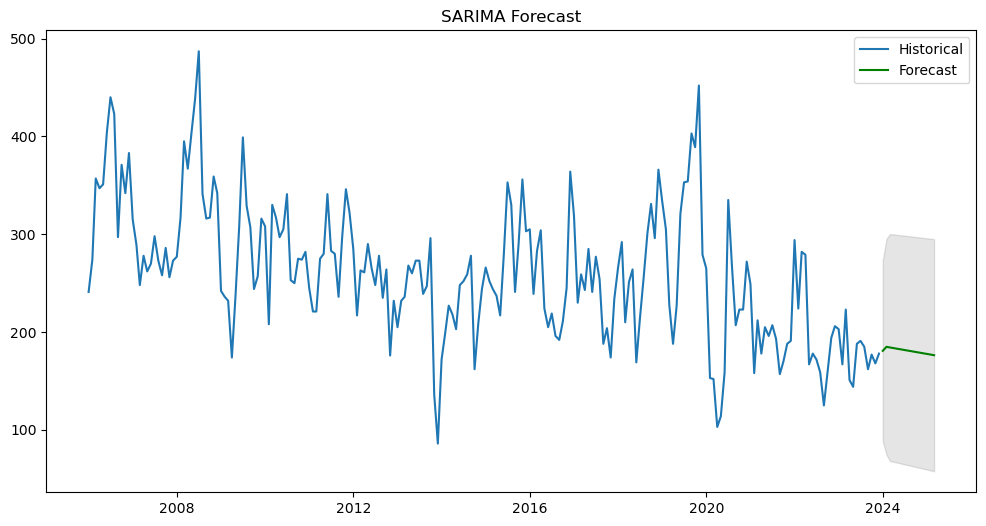

In [19]:
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
future_index = pd.date_range(train.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')
forecast_series = pd.Series(forecast, index=future_index)
plt.figure(figsize=(12,6))
plt.plot(train, label='Historical')
plt.plot(forecast_series, label='Forecast', color='green')
plt.fill_between(future_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('SARIMA Forecast')
plt.show()

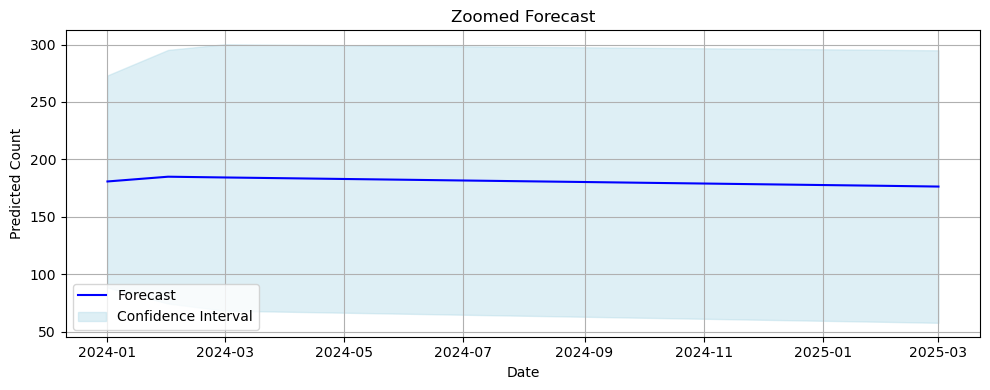

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(forecast_series, label='Forecast', color='blue')
plt.fill_between(forecast_series.index,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='lightblue', alpha=0.4, label='Confidence Interval')
plt.title('Zoomed Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


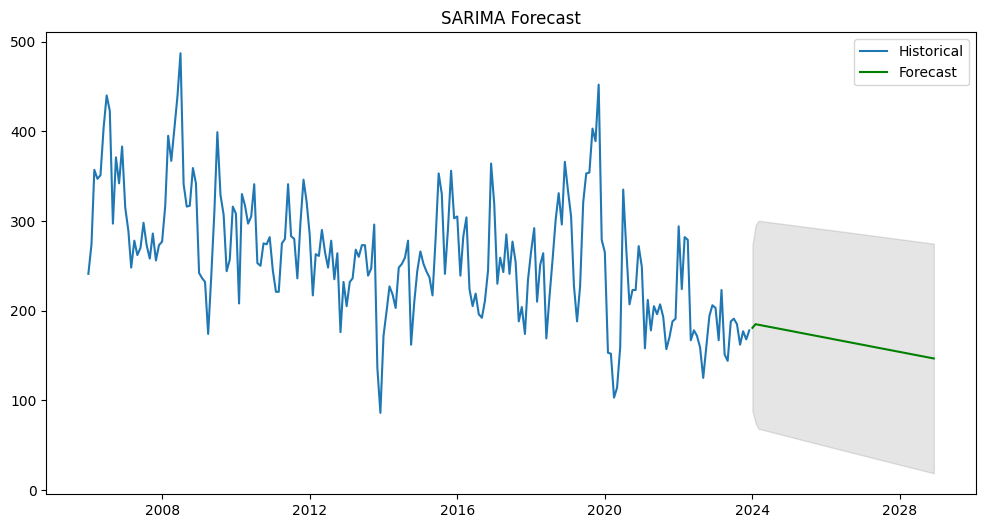

In [21]:
#5 years into future
n_periods = 5 * 12
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
future_index = pd.date_range(train.index[-1] + pd.offsets.MonthBegin(1), periods=n_periods, freq='MS')
forecast_series = pd.Series(forecast, index=future_index)


plt.figure(figsize=(12,6))
plt.plot(train, label='Historical')
plt.plot(forecast_series, label='Forecast', color='green')
plt.fill_between(future_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('SARIMA Forecast')
plt.show()

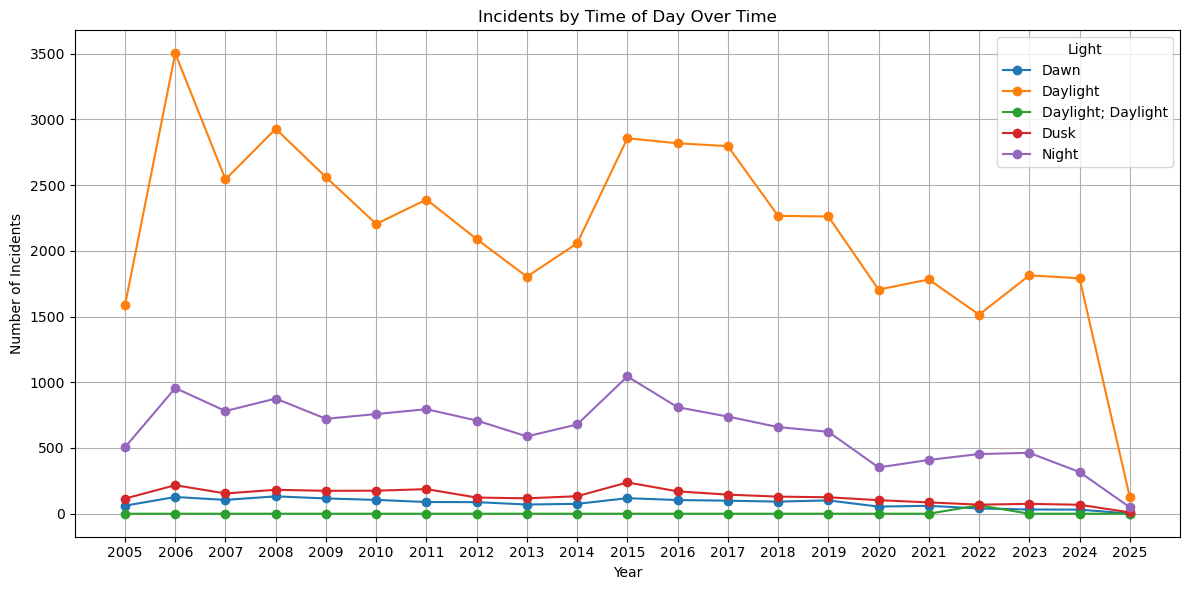

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

#  looking at trends in the number of aviation incidents from 2005 to the present by plotting the top five light conditions (e.g., Daylight, Night) over time.
top_light_conditions = df_final['Light'].value_counts().nlargest(5).index
filtered = df_final[df_final['Light'].isin(top_light_conditions)].copy()

filtered['Year'] = (pd.to_numeric(filtered['Date'], errors='coerce') // 100).astype('Int64')
current_year = datetime.now().year
filtered = filtered[(filtered['Year'] >= 2005) & (filtered['Year'] <= current_year)]
grouped = filtered.groupby(['Year', 'Light']).size().unstack().fillna(0)
grouped.plot(figsize=(12, 6), marker='o')
plt.title('Incidents by Time of Day Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=grouped.index, labels=grouped.index.astype(int))
plt.grid(True)
plt.tight_layout()
plt.show()

4106
Airspace
Class A ZZZ      5622
Class B ZZZ      5211
Class E ZZZ      5125
Class D ZZZ      3196
Class C ZZZ      2408
Class A ZZZ.A    1587
Class G ZZZ      1326
Class B ZZZ.B     959
Class E ZZZ.E     737
Class B SFO       547
Class B LAX       488
Class B DEN       458
Class B ORD       392
Class B EWR       367
Class B ATL       354
Class D TEB.D     322
Class E SCT       322
Class B DFW       316
Class C ZZZ.C     307
Class D ZZZ.D     297
Name: count, dtype: int64


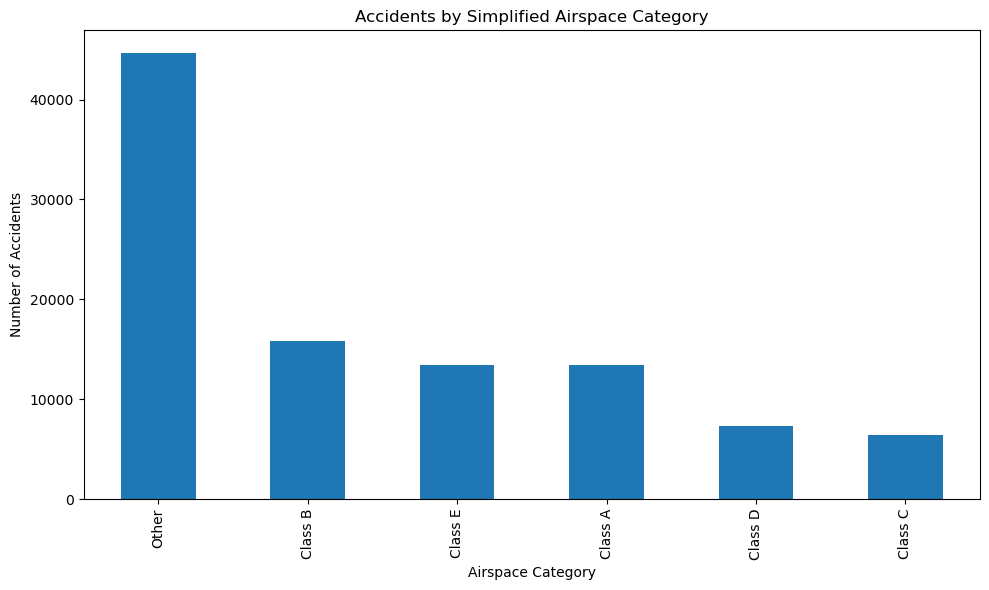

In [ ]:

# cleaned the airspace data to group incidents by standard airspace categories and plotted how many incidents happened in each type. 
print(df_final['Airspace'].nunique())
print(df_final['Airspace'].value_counts().head(20))  # top 20 most common

df_final['Airspace_Clean'] = df_final['Airspace'].str.extract(r'(Class\s[A-E])', expand=False).fillna('Other')

df_final['Airspace_Clean'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Accidents by Simplified Airspace Category')
plt.xlabel('Airspace Category')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

df_final['Airspace_Clean'] = df_final['Airspace_Clean'].fillna('Unknown')

# Class A – High-altitude airspace (above 18,000 ft MSL).
# Class B – Around major airports (e.g., LAX, JFK).
# Class C – Medium-sized airport-controlled airspace.
# Class D – Smaller towered airports.
# Class E – Controlled airspace not classified as A–D (often starts at 700 or 1,200 ft).
# Class G – Uncontrolled airspace (not explicitly labeled often in ASRS).

                                       Aircraft Model  Incident Count
0                               Commercial Fixed Wing            7183
1                                                A320            3870
2                B737 Undifferentiated or Other Model            3360
3                             Skyhawk 172/Cutlass 172            3199
4                                            B757-200            3121
5                                            B737-800            3012
6                                            B737-700            2900
7                                                A319            2717
8                     Regional Jet 200 ER/LR (CRJ200)            2506
9                                   EMB ERJ 145 ER/LR            2345
10                                B767-300 and 300 ER            1963
11                                           B737-300            1710
12                              EMB ERJ 170/175 ER/LR            1687
13  MD-80 Series (DC

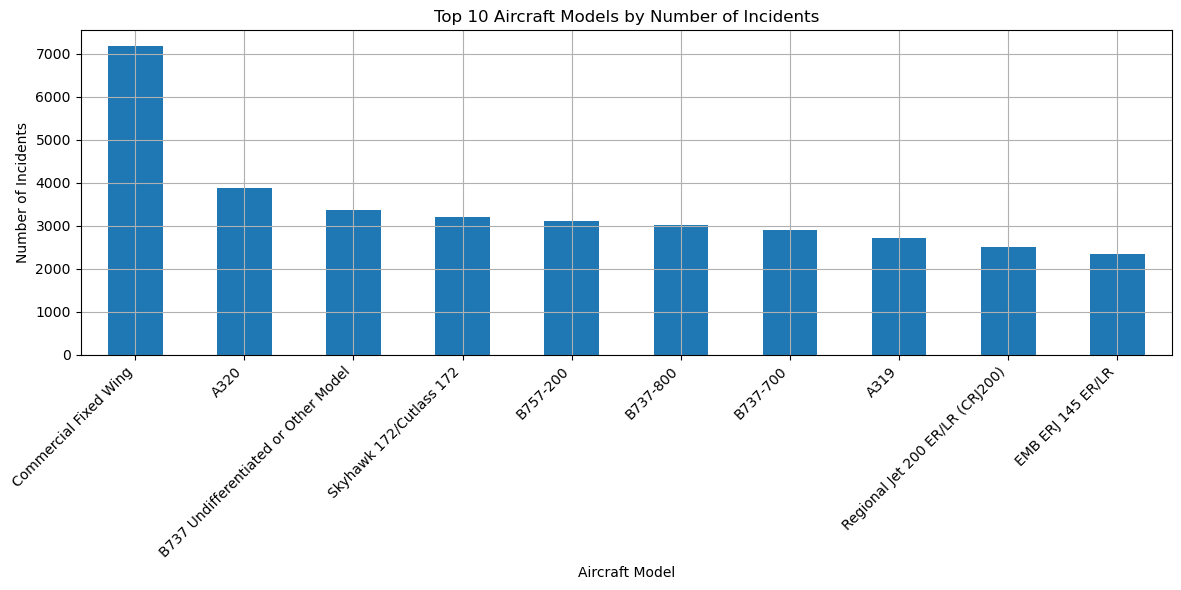

In [ ]:
# Drop rows with missing aircraft model
df_filtered = df_final.dropna(subset=["Make Model Name"])

# Count number of incidents by aircraft model
incident_counts = df_filtered["Make Model Name"].value_counts().reset_index()
incident_counts.columns = ["Aircraft Model", "Incident Count"]

# Show the top 20 aircraft models with the most incidents
print(incident_counts.head(20))

import matplotlib.pyplot as plt

incident_counts.head(10).plot(kind='bar', x='Aircraft Model', y='Incident Count', figsize=(12,6), legend=False)
plt.title('Top 10 Aircraft Models by Number of Incidents')
plt.ylabel('Number of Incidents')
plt.xlabel('Aircraft Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

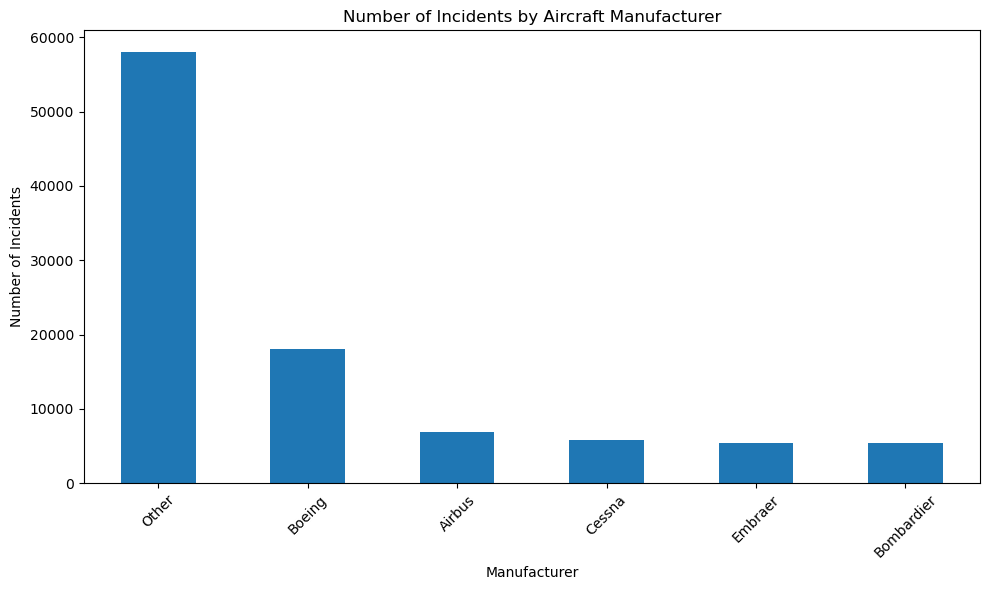

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the manufacturer extraction function
def get_manufacturer(model):
    if pd.isna(model):
        return 'Unknown'
    model = model.upper()
    if 'BOEING' in model or 'B737' in model or 'B757' in model or 'B787' in model:
        return 'Boeing'
    elif 'AIRBUS' in model or 'A320' in model or 'A319' in model:
        return 'Airbus'
    elif 'EMB' in model or 'EMBRAER' in model:
        return 'Embraer'
    elif 'CRJ' in model or 'REGIONAL JET' in model:
        return 'Bombardier'
    elif 'CESSNA' in model or 'SKYHAWK' in model:
        return 'Cessna'
    else:
        return 'Other'

df_filtered['Manufacturer'] = df_filtered['Make Model Name'].apply(get_manufacturer)

manufacturer_counts = df_filtered['Manufacturer'].value_counts()

plt.figure(figsize=(10,6))
manufacturer_counts.plot(kind='bar')
plt.title('Number of Incidents by Aircraft Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()